In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import warnings
warnings.filterwarnings("ignore")

In [3]:
def zscore_2d(matrix):
    matrix_mean = matrix.mean(1, keepdims=True)
    matrix_std = matrix.std(1, keepdims=True)
    return (matrix - matrix_mean) / matrix_std

In [4]:
def get_freq(sampling_rate, level):
    freqs = []
    freq_top = sampling_rate * 0.5
    for i in range(1, level+1):
        start, end = freq_top * 0.5, freq_top
        freqs.append((start, end))
        freq_top = start
    freqs.append((0, freq_top))
    return freqs[::-1]

In [5]:
def load_RealData():
    traindata_path = '../../Data/RealData/all_back_train.npy'
    testdata_path = '../../Data/RealData/all_back_test.npy'

    train_data, test_data = np.load(traindata_path), np.load(testdata_path)
    signals_train, labels_train = train_data[:, :1000], train_data[:, 1000:]
    signals_test, labels_test = test_data[:, :1000], test_data[:, 1000:]

    print(signals_train.shape, labels_test.shape)

    return labels_train, labels_test, zscore_2d(signals_train), zscore_2d(signals_test)

In [6]:
def wavelet_denoise_select(signals, level, wavelet, sampling_rate, show=False):
    filtered_signals = []
    for signal in signals:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dep_freqs = get_freq(sampling_rate, level)

        coeffs_filtered = [np.zeros_like(coeffs[0])] + coeffs[1:5] + [np.zeros_like(c) for c in coeffs[5:]]
        reconstructed_signal = pywt.waverec(coeffs_filtered, wavelet)
        if show:
            print(dep_freqs[1:5])
            plt.figure(figsize=(12, 5))
            plt.plot(signal, label='Noisy Signal')
            plt.plot(reconstructed_signal, label='Filtered Signal')
            plt.legend()
            plt.show()
            break

        filtered_signals.append(reconstructed_signal)
        # break
    return np.array(filtered_signals)

In [7]:
def check_uncertain(signal, window, threshold_uncertain=0.2):
    end = len(signal)
    pieces_indexes = [(start, min(start + window, end)) for start in range(0, end, window)]
    pieced_signals = [signal[begin: over] for begin, over in pieces_indexes]

    def cal_energy(piece):
        return np.sum(np.square(piece))

    pieced_energy = [cal_energy(pieced_signal) for pieced_signal in pieced_signals]

    delta_pieced_energy = np.abs(np.diff(pieced_energy)) / pieced_energy[:-1]
    # delta_pieced_energy = np.array(pieced_energy[1:]) / pieced_energy[:-1]

    if np.sum(delta_pieced_energy <= threshold_uncertain) == len(delta_pieced_energy):
        # 全部符合标准，说明并没有不确定性
        uncertain = 0
    else:
        uncertain = 1

    return uncertain

# for idx in range(0, 300):
#     signal = filtered_signals[idx]
#     delta_energy = check_uncertain(signal, 200)
#
#     zero_crossings = np.where(np.diff(np.sign(signal)))[0]
#     zero_crossings_rate = len(zero_crossings) / (len(signal)-1)
#
#     # print(np.sum(delta_energy <= 0.2))
#     if (np.sum(delta_energy <= 0.2) == len(delta_energy)) and zero_crossings_rate < 0.13:
#         print(delta_energy)
#         print(zero_crossings_rate)
#         plt.figure()
#         plt.plot(filtered_signals[idx])
#         plt.show()

def zcr_and_status(signals, threshold=0.13):
    zcrs, status = [], []

    for cnt, signal in enumerate(signals):
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        zero_crossings_rate = len(zero_crossings) / (len(signal)-1)
        zcrs.append(zero_crossings_rate)

        # 确定是否是uncertain的状态
        uncertain_bool = check_uncertain(signal, window=200)
        if uncertain_bool:
            status.append(-1)
        else:
            if zero_crossings_rate > threshold:
                status.append(0)
            else:
                status.append(1)

    return np.array(zcrs), np.array(status)

In [8]:
def re_status(signals, initial_statuses):
    """I don't need to implement it now."""
    return initial_statuses

def get_good_signals(signals, statuses, zcrs):
    good_signals_idx = []
    for cnt, (status, zcr) in enumerate(zip(statuses, zcrs)):
        if status == 1 and zcr < 0.13:
            good_signals_idx.append(cnt)
    # print(good_signals_idx)
    return signals[good_signals_idx]

In [9]:
from scipy.stats import kurtosis

def movement_detection(signals, show=True, threshold=5):
    for idx in range(len(signals)):
        signal = signals[idx]

        # 定义桶的边界
        bins = np.linspace(min(signal), max(signal), 35)

        # 将数据分到不同的桶中
        hist, bin_edges = np.histogram(signal, bins=bins)

        k = kurtosis(hist)
        if k > 5 and show:
            plt.hist(signal, bins=bins, edgecolor='black')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.title('Histogram')
            plt.show()
            plt.plot(signal)
            plt.show()

In [10]:
from scipy.signal import hilbert
from scipy.signal import savgol_filter

def hilbert_envelope(signals, show=False):
    envelopes = []
    for signal in signals:
        analytic_signal = hilbert(signal)
        amplitude_envelope = np.abs(analytic_signal)
        envelopes.append(amplitude_envelope)

        if show:
            t = np.linspace(0, 1, len(signals[0]), endpoint=False)

            plt.figure(figsize=(10, 3))

            plt.subplot(2, 1, 1)
            plt.plot(t, signal)
            plt.title('signal')

            plt.subplot(2, 1, 2)
            plt.plot(t, amplitude_envelope)
            plt.title('Envelope')

            plt.tight_layout()
            plt.show()
            break
    return np.array(envelopes)


def savgol(signal, window_length=64, order=1):
    filtered_signal = savgol_filter(signal, window_length, order)
    return filtered_signal

def smooth_envelopes(envelopes, window=64):
    smoothed_envelopes = []
    for envelope in envelopes:
        smoothed_envelope = savgol(envelope, window_length=window)
        smoothed_envelopes.append(smoothed_envelope)
    return np.array(smoothed_envelopes)

In [11]:
# acf
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    acf = np.correlate(signal - mean, signal - mean, mode='full') / (np.var(signal) * n)
    return acf[n-1:]

def get_acfs(envelopes):
    acfs = []
    for env in envelopes:
        acf = autocorrelation(env)
        acfs.append(acf)
    return np.array(acfs)

In [12]:
from scipy.signal import welch

def get_psds(acfs, nperseg=256):
    fs = 100
    psds = []
    freqs = []
    for acf in acfs:
        freq, psd = welch(acf, fs=fs, nperseg=nperseg)
        psds.append(psd)
        freqs.append(freq)
    return np.array(psds), np.array(freqs)

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# def softmax(x):
#     exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
#     return exp_x / np.sum(exp_x, axis=1, keepdims=True)

(4672, 1000) (1655, 6)


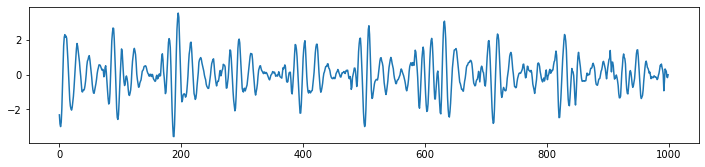

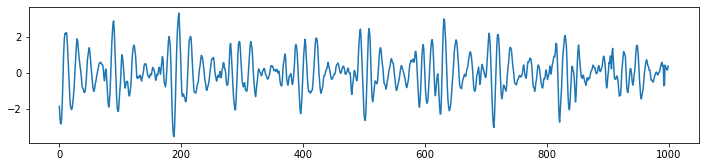

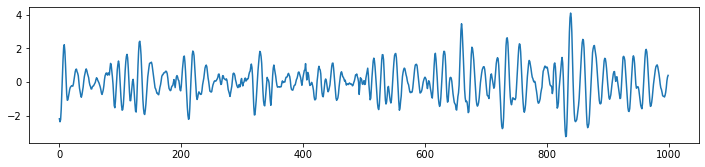

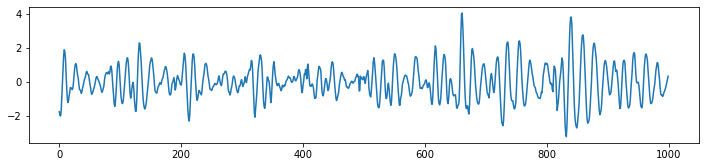

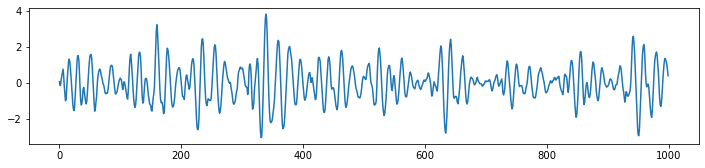

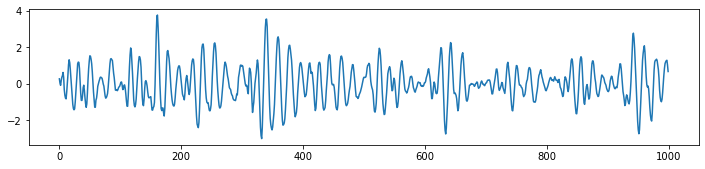

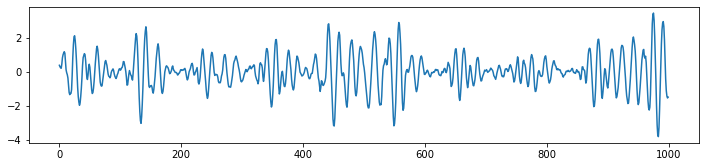

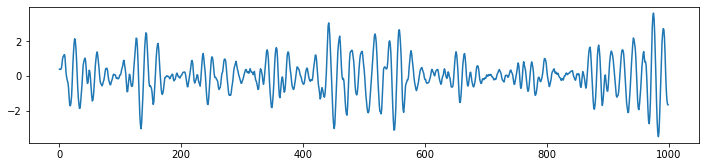

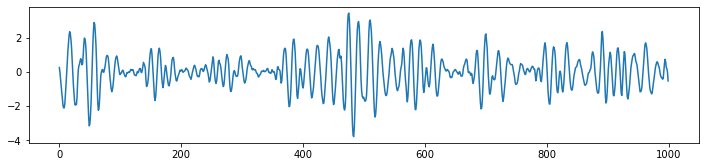

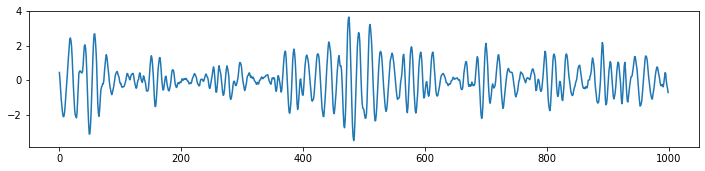

In [14]:
labels_train, labels_test, signals_train, signals_test = load_RealData()
for i in range(10):
    plt.figure(figsize=(12, 2.5))
    plt.plot(signals_train[i])
    plt.show()

In [ ]:

wavelet = 'db12'
level = 6
sampling_rate = 100

filtered_signals = wavelet_denoise_select(signals_train, level, wavelet, sampling_rate)

print(filtered_signals.shape)

zcrs, statuses = zcr_and_status(filtered_signals)
plt.figure(figsize=(6, 4))
plt.plot(zcrs)
plt.title('ZCR')
plt.show()

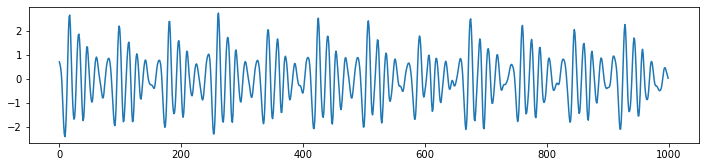

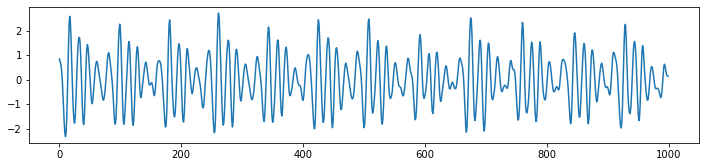

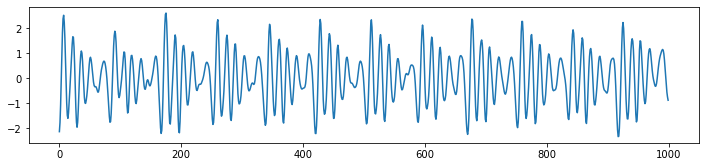

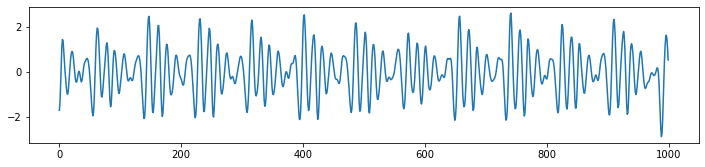

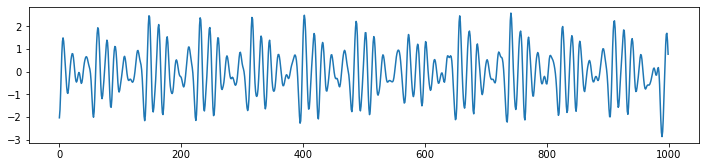

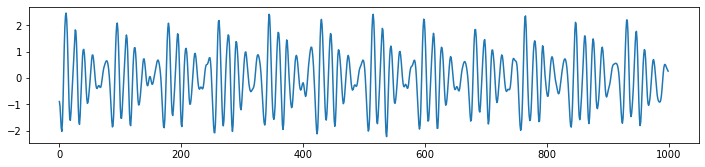

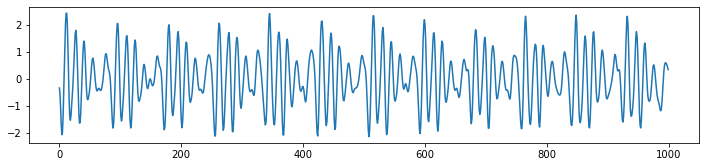

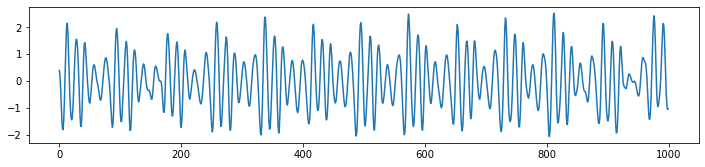

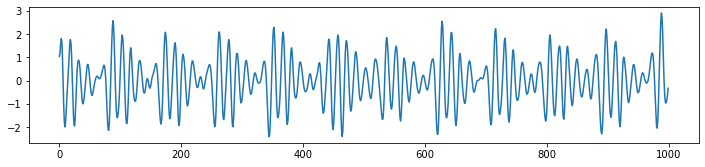

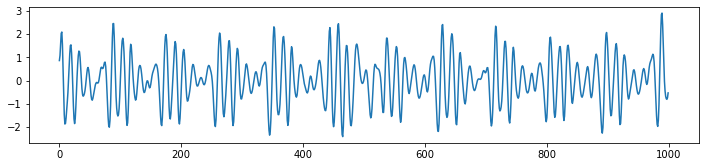

In [25]:

final_statuses = re_status(filtered_signals, statuses)

goods_signals = get_good_signals(filtered_signals, final_statuses, zcrs)
for i in range(10):
    plt.figure(figsize=(12, 2.5))
    plt.plot(goods_signals[i])
    plt.show()

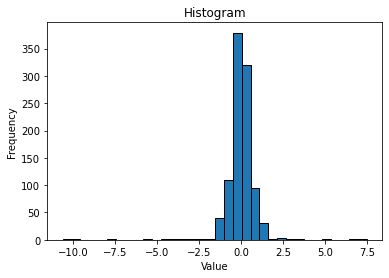

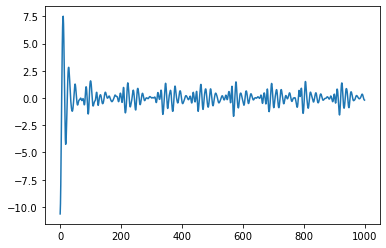

(412, 1000)


In [26]:

movement_detection(filtered_signals)
print(goods_signals.shape)

envelopes = hilbert_envelope(goods_signals)

In [27]:
smoothed_envelopes = smooth_envelopes(envelopes, window=48) # 32-48 is ok

In [28]:
acfs = get_acfs(smoothed_envelopes)

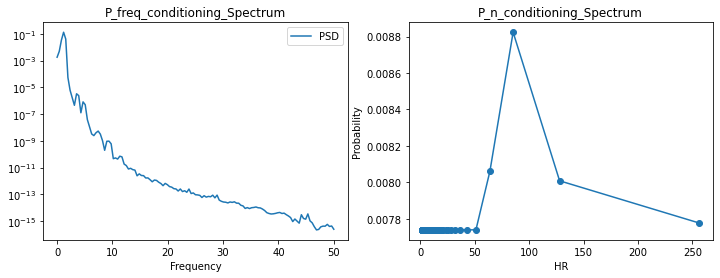

array([         inf, 256.        , 128.        ,  85.33333333,
        64.        ,  51.2       ,  42.66666667,  36.57142857,
        32.        ,  28.44444444,  25.6       ,  23.27272727,
        21.33333333,  19.69230769,  18.28571429,  17.06666667,
        16.        ,  15.05882353,  14.22222222,  13.47368421,
        12.8       ,  12.19047619,  11.63636364,  11.13043478,
        10.66666667,  10.24      ,   9.84615385,   9.48148148,
         9.14285714,   8.82758621,   8.53333333,   8.25806452,
         8.        ,   7.75757576,   7.52941176,   7.31428571,
         7.11111111,   6.91891892,   6.73684211,   6.56410256,
         6.4       ,   6.24390244,   6.0952381 ,   5.95348837,
         5.81818182,   5.68888889,   5.56521739,   5.44680851,
         5.33333333,   5.2244898 ,   5.12      ,   5.01960784,
         4.92307692,   4.83018868,   4.74074074,   4.65454545,
         4.57142857,   4.49122807,   4.4137931 ,   4.33898305,
         4.26666667,   4.19672131,   4.12903226,   4.06

In [37]:
psds, freqs = get_psds(acfs, 256)

# plt.plot(freqs, psds)

psds_PDF = softmax(psds)
ns_from_spectrum = 100 / freqs

P_n_con_spectrum_Y = psds_PDF
P_n_con_spectrum_X = 100 / freqs

cnt = 1

plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(121)
plt.semilogy(freqs[cnt], psds[cnt], label='PSD')
plt.title('P_freq_conditioning_Spectrum')
plt.xlabel('Frequency')
plt.legend()
# plt.show()

plt.subplot(122)
plt.title('P_n_conditioning_Spectrum')
plt.plot(P_n_con_spectrum_X[cnt], P_n_con_spectrum_Y[cnt])
plt.scatter(P_n_con_spectrum_X[cnt], P_n_con_spectrum_Y[cnt])
plt.xlabel('HR')
plt.ylabel('Probability')
plt.show()
len(P_n_con_spectrum_X[cnt])
P_n_con_spectrum_X[cnt]

66

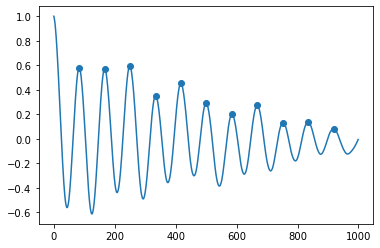

In [194]:
from scipy.signal import find_peaks
abab = 1
peaks, _ = find_peaks(acfs[abab])
plt.plot(acfs[abab])
plt.scatter(peaks, acfs[abab, peaks])
n = len(peaks)
n * 6

(4672, 1000) (1655, 6)
(272, 1000)


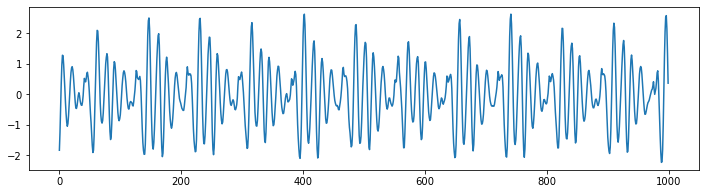

(272, 1000)


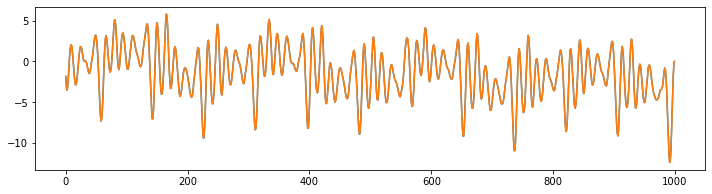

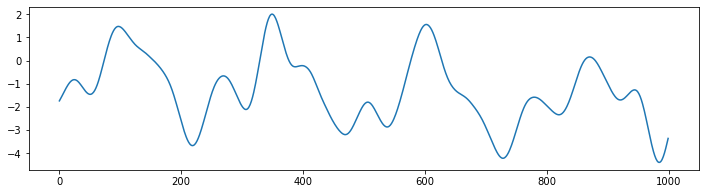

In [226]:
if __name__ == '__main__':
    def wavelet_denoise_select_RR(signals, level, wavelet, sampling_rate, show=False):
        filtered_signals = []
        for signal in signals:
            coeffs = pywt.wavedec(signal, wavelet, level=level)
            dep_freqs = get_freq(sampling_rate, level)

            # coeffs_filtered = [np.zeros_like(coeffs[0])] + coeffs[1:3] + [np.zeros_like(c) for c in coeffs[3:]]

            intern = 2
            coeffs_filtered = coeffs[:intern] + [np.zeros_like(c) for c in coeffs[intern:]]
            reconstructed_signal = pywt.waverec(coeffs_filtered, wavelet)
            if show:
                print(dep_freqs[1:5])
                plt.figure(figsize=(12, 5))
                plt.plot(signal, label='Noisy Signal')
                plt.plot(reconstructed_signal, label='Filtered Signal')
                plt.legend()
                plt.show()
                break

            filtered_signals.append(reconstructed_signal)
        return np.array(filtered_signals)
    def autocorrelation(signal):
        n = len(signal)
        mean = np.mean(signal)
        acf = np.correlate(signal - mean, signal - mean, mode='full') / (np.var(signal) * n)
        return acf[n-1:]

    def get_acfs(envelopes):
        acfs = []
        for env in envelopes:
            acf = autocorrelation(env)
            acfs.append(acf)
        return np.array(acfs)


    _, _, signals_train, _ = load_RealData()

    zcrs, statuses = zcr_and_status(signals_train)
    final_statuses = re_status(signals_train, statuses)

    goods_signals = get_good_signals(signals_train, final_statuses, zcrs)

    print(goods_signals.shape)
    aa = 3
    plt.figure(figsize=(12, 3))
    plt.plot(goods_signals[aa])
    plt.show()
    plt.figure(figsize=(12, 3))
    plt.plot(np.cumsum(goods_signals[aa]))

    wavelet = 'db12'
    level = 6
    sampling_rate = 100

    cumsum_goods_signals = np.cumsum(goods_signals, 1)
    plt.plot(cumsum_goods_signals[aa])

    print(cumsum_goods_signals.shape)

    filtered_cumsum_signals = wavelet_denoise_select_RR(cumsum_goods_signals, level, wavelet, sampling_rate)
    plt.figure(figsize=(12, 3))
    plt.plot(filtered_cumsum_signals[4])
    # get_acfs()

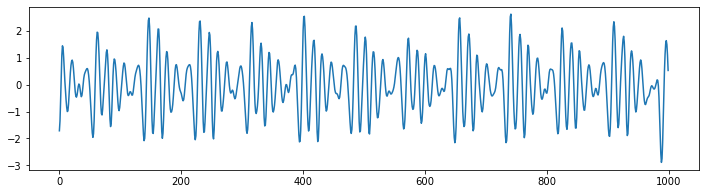

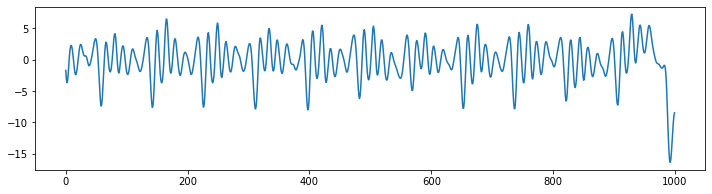

In [210]:
np.cumsum([1, 12, 4, 5])

array([ 1, 13, 17, 22])

In [ ]:
show = 1
if show:
    for cnt, signal in enumerate(goods_signals):
        print(zcrs[cnt])
        print(final_statuses[cnt])
        plt.figure(figsize=(12, 3))
        # plt.plot()
        plt.plot(signal)
        plt.plot(smoothed_envelopes[cnt])
        plt.show()
        if cnt > 20:
            break

In [11]:
# labels_train, labels_test, signals_train, signals_test = load_RealData()
# wavelet = 'db12'
# level = 6
# sampling_rate = 100
#
# filtered_signals_test = wavelet_denoise_select(signals_test, level, wavelet, sampling_rate)
# filtered_signals_train = wavelet_denoise_select(signals_train, level, wavelet, sampling_rate)
#
# print(filtered_signals_train.shape, filtered_signals_test.shape)
#
# # np.save( '../../Data/RealData/filtered_signals_train', filtered_signals_train)
# # np.save('../../Data/RealData/filtered_signals_test', filtered_signals_test )
#
# zcrs_train, onbeds_train, offbeds_train = zcr(filtered_signals_train)
# zcrs_test, onbeds_test, offbeds_test = zcr(filtered_signals_test)
#
# for cnt, i in enumerate(offbeds_train):
#     plt.plot()
#     plt.plot(filtered_signals_train[i])
#     plt.show()
#     if cnt > 20:
#         break

(129,)
(129,)
(129,)
(129,)
(129,)
(129,)
(129,)
(129,)
(129,)
(129,)


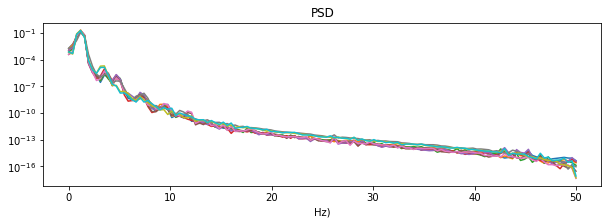

In [133]:
import numpy as np
import matplotlib.pyplot as plt
